# House Sales Prediction with Random Forest and Gradient Boosting

In [ ]:
# base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='deep', style='whitegrid')

# data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# ensebles
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.ensemble import GradientBoostingRegressor as GB
from ensembles import RandomForestMSE
from ensembles import GradientBoostingMSE

# utils
from tqdm.notebook import tqdm_notebook as tqdm
from matplotlib.ticker import FuncFormatter
from time import time
%load_ext autoreload
%autoreload 2

In [ ]:
! mkdir /content/drive/MyDrive/mmp_gb

mkdir: cannot create directory ‘/content/drive/MyDrive/mmp_gb’: File exists


## Download Data

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets list -s king

ref                                                      title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
harlfoxem/housesalesprediction                           House Sales in King County, USA                    780KB  2016-08-25 15:52:49         152197       1907  0.7058824        
kinguistics/heartbeat-sounds                             Heartbeat Sounds                                   110MB  2016-11-27 01:33:54          16923        536  0.7647059        
mayureshkoli/best-universities-in-the-united-kingdom     Best Universities in the United Kingdom              9KB  2022-08-05 05:32:37           1881         41  1.0              
jessemostipak/hotel-booking-demand                       Hotel booking demand                       

In [ ]:
! kaggle datasets download -d harlfoxem/housesalesprediction

100% 780k/780k [00:00<00:00, 1.67MB/s]
100% 780k/780k [00:00<00:00, 1.67MB/s]


In [ ]:
! mkdir data
! unzip housesalesprediction.zip -d data

Archive:  housesalesprediction.zip
  inflating: data/kc_house_data.csv  


In [ ]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## Preprocess

In [ ]:
df.drop(columns=['id'], inplace=True)

In [ ]:
df.date = pd.to_datetime(df.date, format="%Y%m%dT000000")

In [ ]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day'] = df.date.dt.day
df.drop(columns=['date'], inplace=True)

In [ ]:
df.year.unique()

array([2014, 2015])

In [ ]:
sorted(df.month.unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [ ]:
print(sorted(df.day.unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [ ]:
! pip install feature_engine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 290 kB 2.4 MB/s 


In [ ]:
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=['month', 'day'], drop_original=True)

df = cyclical.fit_transform(df)

In [ ]:
df = pd.get_dummies(df, columns=['year'], prefix=['year'])
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,month_sin,month_cos,day_sin,day_cos,year_2014,year_2015
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,-8.660254e-01,0.5,0.485302,-0.874347,1,0
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,...,47.7210,-122.319,1690,7639,-2.449294e-16,1.0,0.968077,-0.250653,1,0
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,47.7379,-122.233,2720,8062,8.660254e-01,0.5,-0.937752,0.347305,0,1
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,...,47.5208,-122.393,1360,5000,-2.449294e-16,1.0,0.968077,-0.250653,1,0
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,47.6168,-122.045,1800,7503,8.660254e-01,0.5,-0.485302,-0.874347,0,1


In [ ]:
X, y = df.drop(columns=['price']), df.price

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = \
    train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [ ]:
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

X_train = X_train.to_numpy()
X_val = X_val.to_numpy()
X_test = X_test.to_numpy()

## Experiments

### My RF

#### Subspace Size

In [ ]:
# for further extracting best param
subspace_size_results = None

# search space
subspace_sizes = np.linspace(1e-3, 1, 10)

# container for result
subspace_size_df = pd.DataFrame()

# repeat experiment 3 times
for i in range(3):
  subspace_size_results = []
  subspace_size_timers = []
  for subspace_size in tqdm(subspace_sizes):
    reg = RandomForestMSE(n_estimators=100,
                          max_depth=40,
                          feature_subsample_size=subspace_size)
    start = time()
    reg.fit(X_train, y_train)
    end = time()
    y_pred = reg.predict(X_val)
    timer = end - start
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    # record rmse of current param
    subspace_size_results.append(score)
    subspace_size_timers.append(timer)
  
  # record results of this experiment
  tmp = pd.DataFrame(
      zip(subspace_size_results, subspace_size_timers, subspace_sizes),
      columns=['RMSE', 'time', 'subspace_size'])
  subspace_size_df = pd.concat([subspace_size_df, tmp], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

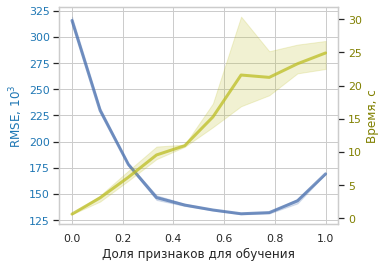

In [ ]:
plt.figure(figsize=(5, 4))

ax = sns.lineplot(x=subspace_size_df.subspace_size,
                  y=subspace_size_df.RMSE,
                  linewidth=3, alpha=0.75)
ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000)))
ax.set_xlabel('Доля признаков для обучения')
ax.set_ylabel(r'RMSE, $10^3$', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax.twinx()
sns.lineplot(ax=ax2, x=subspace_size_df.subspace_size,
             y=subspace_size_df.time,
             linewidth=3, alpha=0.75, color='tab:olive')
ax2.set_ylabel(r'Время, с', color='olive')
ax2.tick_params(axis='y', labelcolor='olive')
ax2.grid()

plt.savefig('/content/drive/MyDrive/mmp_gb/feature_fraction.pdf',
            bbox_inches='tight')
plt.show()

In [ ]:
subspace_size = subspace_sizes[np.argmin(subspace_size_results)]
subspace_size

0.667

#### Max Depth

In [ ]:
# for further extracting best param
max_depth_results = None

# search space
max_depths = np.arange(5, 51, 5, dtype='int')

# container for result
max_depth_df = pd.DataFrame()

# repeat experiment 3 times
for i in range(3):
  max_depth_results = []
  max_depth_timers = []
  for max_depth in tqdm(max_depths):
    reg = RandomForestMSE(n_estimators=100,
                          max_depth=max_depth,
                          feature_subsample_size=subspace_size)
    start = time()
    reg.fit(X_train, y_train)
    end = time()
    y_pred = reg.predict(X_val)
    timer = end - start
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    # record rmse of current param
    max_depth_timers.append(timer)
    max_depth_results.append(score)
  
  # record results of this experiment
  tmp = pd.DataFrame(
      zip(max_depth_results, max_depth_timers, max_depths),
      columns=['RMSE', 'time', 'max_depth'])
  max_depth_df = pd.concat([max_depth_df, tmp], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

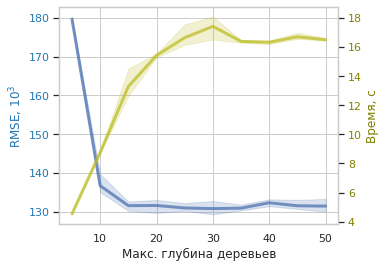

In [ ]:
plt.figure(figsize=(5, 4))

ax = sns.lineplot(x=max_depth_df.max_depth,
                  y=max_depth_df.RMSE,
                  linewidth=3, alpha=0.75)

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000)))
ax.set_xlabel('Макс. глубина деревьев')
ax.set_ylabel(r'RMSE, $10^3$', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax.twinx()
sns.lineplot(ax=ax2,
             x=max_depth_df.max_depth,
             y=max_depth_df.time,
             linewidth=3, alpha=0.75, color='tab:olive')
ax2.set_ylabel(r'Время, с', color='olive')
ax2.tick_params(axis='y', labelcolor='olive')
ax2.grid()

plt.savefig('/content/drive/MyDrive/mmp_gb/max_depth.pdf',
            bbox_inches='tight')
plt.show()

In [ ]:
max_depth = max_depths[np.argmin(max_depth_results)]
max_depth

30

#### Estimators Count

In [ ]:
# for further extracting best param
n_estimators_results = None

# search space
n_estimatorss = np.arange(20, 301, 20, dtype='int')

# container for result
n_estimators_df = pd.DataFrame()

# repeat experiment 3 times
for i in range(6):
  n_estimators_results = []
  n_estimators_timers = []
  for n_estimators in tqdm(n_estimatorss):
    reg = RandomForestMSE(n_estimators=n_estimators,
                          max_depth=max_depth,
                          feature_subsample_size=subspace_size)
    start = time()
    reg.fit(X_train, y_train)
    end = time()
    y_pred = reg.predict(X_val)
    timer = end - start
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    # record rmse of current param
    n_estimators_timers.append(timer)
    n_estimators_results.append(score)
  
  # record results of this experiment
  tmp = pd.DataFrame(
      zip(n_estimators_results, n_estimators_timers, n_estimatorss),
      columns=['RMSE', 'time', 'n_estimators'])
  n_estimators_df = pd.concat([n_estimators_df, tmp], ignore_index=True)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

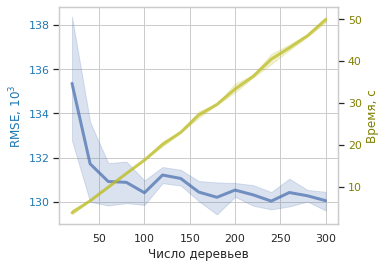

In [ ]:
plt.figure(figsize=(5, 4))

ax = sns.lineplot(x=n_estimators_df.n_estimators,
                  y=n_estimators_df.RMSE,
                  linewidth=3, alpha=0.75)

ax.yaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000)))
ax.set_xlabel('Число деревьев')
ax.set_ylabel(r'RMSE, $10^3$', color='tab:blue')
ax.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax.twinx()
sns.lineplot(ax=ax2,
             x=n_estimators_df.n_estimators,
             y=n_estimators_df.time,
             linewidth=3, alpha=0.75, color='tab:olive')
ax2.set_ylabel(r'Время, с', color='olive')
ax2.tick_params(axis='y', labelcolor='olive')
ax2.grid()

plt.savefig('/content/drive/MyDrive/mmp_gb/n_estimators.pdf',
            bbox_inches='tight')
plt.show()

### sklearn RF

In [ ]:
reg = RF(n_estimators=100, bootstrap=False)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mean_squared_error(y_test.values, y_pred, squared=False)

174659.81954195633

In [ ]:
y_pred

array([282624.03, 489180.95, 834435.45, ..., 489629.29, 268783.01,
       675642.68])

In [ ]:
y_test.values

array([307700., 935000., 862500., ..., 408506., 210000., 739900.])

In [ ]:
# optuna_args = {
#     'objective_func': sk_rf,
#     'n_trials': 50,
#     'n_jobs': 4,
#     'study_direction': 'minimize',
#     'sampler': tpe_sampler
# }

# sk_rf_study = start_optimization(**optuna_args)

### My GB

In [ ]:
gb = GradientBoostingMSE(n_estimators=250, learning_rate=.1)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test.values, y_pred, squared=False)

143235.0291195123

#### Зона адекватных параметров

In [ ]:
optuna_args = {
    'objective_func': my_gb,
    'n_trials': 100,
    'n_jobs': 4,
    'study_direction': 'minimize',
    'sampler': tpe_sampler
}

my_gb_study = start_optimization(**optuna_args)

[I 2022-12-08 20:10:07,282] A new study created in memory with name: no-name-9fbb9a84-33cc-4164-81c8-74e12301919e
[I 2022-12-08 20:10:15,123] Trial 3 finished with value: 622632.7711574394 and parameters: {'n_estimators': 177, 'feature_subsample_size': 0.02198095327152172, 'max_depth': 18, 'learning_rate': 0.0003931297984289968}. Best is trial 3 with value: 622632.7711574394.
[I 2022-12-08 20:10:18,994] Trial 2 finished with value: 635926.0279206745 and parameters: {'n_estimators': 15, 'feature_subsample_size': 0.9578611152393093, 'max_depth': 49, 'learning_rate': 0.002054073426942803}. Best is trial 3 with value: 622632.7711574394.
[I 2022-12-08 20:10:51,611] Trial 0 finished with value: 140856.8418939885 and parameters: {'n_estimators': 164, 'feature_subsample_size': 0.4276334311222094, 'max_depth': 13, 'learning_rate': 0.023969233943147827}. Best is trial 0 with value: 140856.8418939885.
[I 2022-12-08 20:11:11,567] Trial 5 finished with value: 520116.85056673206 and parameters: {'n_

In [ ]:
optuna.visualization.plot_slice(my_gb_study)

In [ ]:
optuna.visualization.plot_contour(my_gb_study)

In [ ]:
my_gb_study.best_params

{'n_estimators': 41,
 'feature_subsample_size': 0.7624966341101597,
 'max_depth': 8,
 'learning_rate': 0.23461645895959823}

#### Learning Rate

In [ ]:
# for further extracting best param
lr_results = None

# search space
lrs = np.logspace(-3, 0.3, 10)

# container for result
lr_df = pd.DataFrame()

# repeat experiment 3 times
for i in range(3):
  lr_results = []
  lr_timers = []
  for lr in tqdm(lrs):
    reg = GradientBoostingMSE(n_estimators=100,
                              max_depth=40,
                              feature_subsample_size=subspace_size,
                              learning_rate=lr)
    start = time()
    reg.fit(X_train, y_train)
    end = time()
    y_pred = reg.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)
    timer = end - start
    
    # record rmse of current param
    lr_results.append(score)
    lr_timers.append(timers)
  
  # record results of this experiment
  tmp = pd.DataFrame(zip(lr_results, lr_timers, lrs), columns=['RMSE', 'time', 'lr'])
  lr_df = pd.concat([lr_df, tmp], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

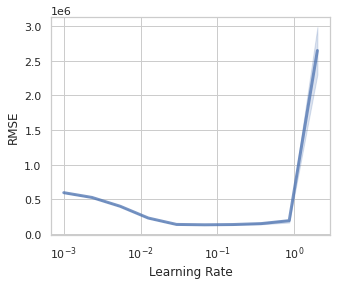

In [ ]:
plt.figure(figsize=(5, 4))
ax = sns.lineplot(x=lr_df.lr, y=lr_df.RMSE, linewidth=3, alpha=0.75)
plt.xlabel('Learning Rate')
plt.ylabel(r'RMSE')
plt.xscale('log')
# plt.yscale('log')
plt.savefig('/content/drive/MyDrive/mmp_gb/lr.pdf', bbox_inches='tight')
plt.show()

In [ ]:
lr = lrs[np.argmin(lr_results)]
lr

0.15848931924611126

#### Subspace Size

In [ ]:
# for further extracting best param
gbsubspace_size_results = None

# search space
gbsubspace_sizes = np.linspace(1e-3, 1, 10)

# container for result
gbsubspace_size_df = pd.DataFrame()

# repeat experiment 3 times
for i in range(3):
  gbsubspace_size_results = []
  for subspace_size in tqdm(gbsubspace_sizes):
    reg = GradientBoostingMSE(n_estimators=100,
                              max_depth=40,
                              feature_subsample_size=subspace_size,
                              learning_rate=lr)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    # record rmse of current param
    gbsubspace_size_results.append(score)
  
  # record results of this experiment
  tmp = pd.DataFrame(zip(gbsubspace_size_results, gbsubspace_sizes), columns=['RMSE', 'subspace_size'])
  gbsubspace_size_df = pd.concat([gbsubspace_size_df, tmp], ignore_index=True)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

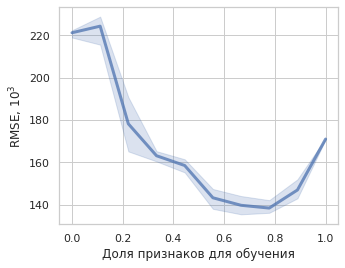

In [ ]:
plt.figure(figsize=(5, 4))
ax = sns.lineplot(x=gbsubspace_size_df.subspace_size, y=gbsubspace_size_df.RMSE, linewidth=3, alpha=0.75)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000)))
plt.xlabel('Доля признаков для обучения')
plt.ylabel(r'RMSE, $10^3$')
plt.savefig('/content/drive/MyDrive/mmp_gb/gbfeature_fraction.pdf', bbox_inches='tight')
plt.show()

In [ ]:
gbsubspace_size = gbsubspace_sizes[np.argmin(gbsubspace_size_results)]
gbsubspace_size

0.667

#### Max Depth

In [ ]:
# for further extracting best param
gbmax_depth_results = None

# search space
gbmax_depths = list(range(1,11)) + [20,30,40,50]

# container for result
gbmax_depth_df = pd.DataFrame()

# repeat experiment 3 times
for i in range(3):
  gbmax_depth_results = []
  for max_depth in tqdm(gbmax_depths):
    reg = GradientBoostingMSE(n_estimators=100,
                              max_depth=max_depth,
                              feature_subsample_size=gbsubspace_size,
                              learning_rate=lr)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    # record rmse of current param
    gbmax_depth_results.append(score)
  
  # record results of this experiment
  tmp = pd.DataFrame(zip(gbmax_depth_results, gbmax_depths), columns=['RMSE', 'max_depth'])
  gbmax_depth_df = pd.concat([gbmax_depth_df, tmp], ignore_index=True)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

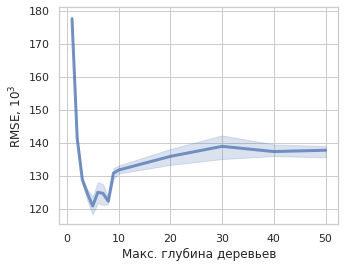

In [ ]:
plt.figure(figsize=(5, 4))
ax = sns.lineplot(x=gbmax_depth_df.max_depth, y=gbmax_depth_df.RMSE, linewidth=3, alpha=0.75)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000)))
plt.xlabel('Макс. глубина деревьев')
plt.ylabel(r'RMSE, $10^3$')
# plt.xscale('log')x
plt.savefig('/content/drive/MyDrive/mmp_gb/gbmax_depth.pdf', bbox_inches='tight')
plt.show()

In [ ]:
gbmax_depth = gbmax_depths[np.argmin(gbmax_depth_results)]
gbmax_depth

5

#### Estimators Count

In [ ]:
# for further extracting best param
gbn_estimators_results = None

# search space
gbn_estimatorss = np.arange(20, 401, 38, dtype='int')

# container for result
gbn_estimators_df = pd.DataFrame()

# repeat experiment 3 times
for i in range(6):
  gbn_estimators_results = []
  for n_estimators in tqdm(gbn_estimatorss):
    reg = GradientBoostingMSE(n_estimators=n_estimators,
                          max_depth=gbmax_depth,
                          feature_subsample_size=gbsubspace_size,
                          learning_rate=lr)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_val)
    score = mean_squared_error(y_val, y_pred, squared=False)
    
    # record rmse of current param
    gbn_estimators_results.append(score)
  
  # record results of this experiment
  tmp = pd.DataFrame(zip(gbn_estimators_results, gbn_estimatorss), columns=['RMSE', 'n_estimators'])
  gbn_estimators_df = pd.concat([gbn_estimators_df, tmp], ignore_index=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

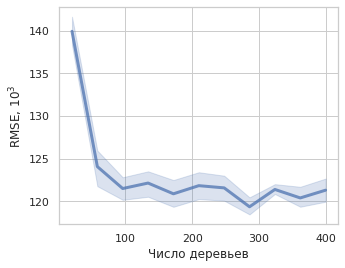

In [ ]:
plt.figure(figsize=(5, 4))
ax = sns.lineplot(x=gbn_estimators_df.n_estimators, y=gbn_estimators_df.RMSE, linewidth=3, alpha=0.75)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0f}'.format(x/1000)))
plt.xlabel('Число деревьев')
plt.ylabel(r'RMSE, $10^3$')
plt.savefig('/content/drive/MyDrive/mmp_gb/gbn_estimators.pdf', bbox_inches='tight')
plt.show()

In [ ]:
gbn_estimatorss

array([ 20,  58,  96, 134, 172, 210, 248, 286, 324, 362, 400])

### sklearn GB

In [ ]:
gbreg = GB(n_estimators=100, learning_rate=1e-1)
gbreg.fit(X_train, y_train)
y_pred = gbreg.predict(X_test)
mean_squared_error(y_test.values, y_pred, squared=False)

131966.9961636143

In [ ]:
y_pred

array([279229.8324376 , 482220.48165852, 847332.02107435, ...,
       453310.74045917, 244867.87952333, 737125.60258788])

In [ ]:
y_test.values

array([307700., 935000., 862500., ..., 408506., 210000., 739900.])

In [ ]:
optuna_args = {
    'objective_func': sk_gb,
    'n_trials': 50,
    'n_jobs': 4,
    'study_direction': 'minimize',
    'sampler': tpe_sampler
}

sk_gb_study = start_optimization(**optuna_args)